# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (2da entrega)

## Fecha de entrega

3 de Junio 2025

## Integrantes

Leonardo, Gonzalez

Federico, Alberetti

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la función de ejemplo (`ruidoRosa_voss`)(1er entrega).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) (con las celdas ejecutas) y todos los archivos para reproducir los resultados por Slack.
* Todas las señales de audio deben ser grabadas en formato .wav en la misma función que las genera.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import signal
import soundfile as sf

from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np

from scipy.io.wavfile import write

## Descargar dataset
El objetivo es tener archivos para validar el software creado , para lo cual es necesario contar con la información y los datos de la medición.

### 1. Respuestas al impulso: 
**Consigna:** Descargar **al menos dos** respuestas al impulso (RI o en ingles IR, Impulse Responses) de dos recintos distintos del siguiente [link](https://www.openair.hosted.york.ac.uk/?page_id=36) y toda la información relevante de la medición, ademas de los resultados de los parametros acústicos calculados (para luego comparar). También se pueden usar los archivos dispuestos en el Drive de la asignatura. 

### 2. Sine sweep logarítmico + filtro inverso: 
**Consigna:** Descargar **al menos un** sine sweep con su respectivo filtro inverso. Una posibildiad es usar los archivos dispuestos en el GDrive de la asignatura. Para generar el filtro inverso usar la info brindada por el informe técnico en la misma carpeta de los archivos. 

## Función de carga de archivos de audio

**Consigna:** realizar una función que permita cargar archivos de audio, en lo posible \*.wav, por ejemplo los archivos anteriormente descargados. Contemplar el ingreso de más de un archivo de audio, por tipo.

In [2]:
# Lista global para almacenar los archivos seleccionados
files = []

def select_and_load_files(b):
    clear_output()  # Limpia la salida en Jupyter
    root = Tk()
    root.withdraw()  # Oculta la ventana principal de Tkinter
    root.call('wm', 'attributes', '.', '-topmost', True)  # Levanta el diálogo al frente

    # Permite seleccionar múltiples archivos WAV
    selected_files = filedialog.askopenfilenames(
        title="Seleccione archivos WAV",
        filetypes=[("Archivos WAV", ".wav"), ("Todos los archivos", ".*")]
    )
    
    # Agregar los archivos seleccionados a la lista global
    files.extend(selected_files)
    
    # Mostrar la lista de archivos seleccionados
    print("Archivos seleccionados:")
    for archivo in files:
        print(f"- {archivo}")
    
    # Procesar cada archivo WAV seleccionado
    for archivo in files:
        try:
            # Cargar el archivo WAV
            audio_data, sample_rate = sf.read(archivo)
            
            # Mostrar información del archivo
            print(f"\nArchivo: {archivo}")
            print(f"Frecuencia de muestreo: {sample_rate} Hz")
            print(f"Duración: {len(audio_data) / sample_rate:.2f} segundos")
            
            # Graficar la señal de audio
            time = np.linspace(0, len(audio_data) / sample_rate, num=len(audio_data))
            plt.figure(figsize=(10, 4))
            plt.plot(time, audio_data, color='blue')
            plt.xlabel("Tiempo (s)")
            plt.ylabel("Amplitud")
            plt.title(f"Señal de: {archivo.split('/')[-1]}")
            plt.grid(True)
            plt.show()
        
        except Exception as e:
            print(f"Error al cargar {archivo}: {e}")

# Crear el botón interactivo
fileselect = Button(description="Seleccione archivos WAV")
fileselect.on_click(select_and_load_files)

# Mostrar el botón en la celda de Jupyter
display(fileselect)

# La variable 'files' contiene la lista de archivos seleccionados
files




Button(description='Seleccione archivos WAV', style=ButtonStyle())

[]

Llamar a la función con uno de los ejemplos anteriormente descargados y usar la función de visualización de la 1er entrega.

Archivos seleccionados:
- /Users/federicoalberetti/TP_sys_1ra_entrega_Gonzalez_Alberetti-1/RI_Tercios_Octava.wav

Archivo: /Users/federicoalberetti/TP_sys_1ra_entrega_Gonzalez_Alberetti-1/RI_Tercios_Octava.wav
Frecuencia de muestreo: 44100 Hz
Duración: 40.00 segundos


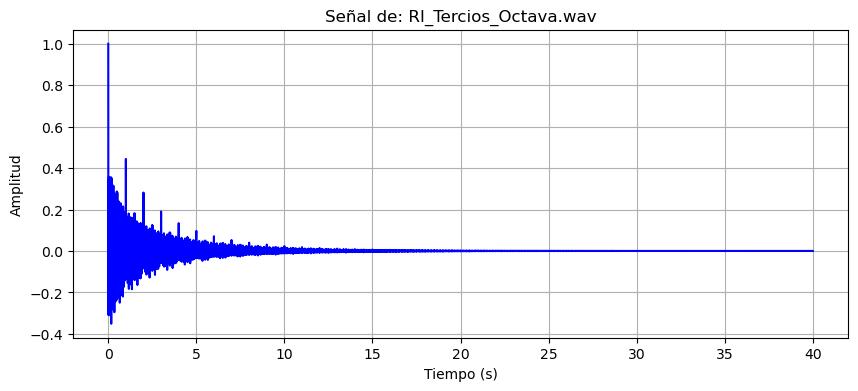

In [3]:
select_and_load_files(fileselect)  # Llamar a la función para cargar archivos al inicio

## Función de sintetización de respuesta al impulso

**Consigna:** realizar una función para sintetizar una respuesta al impulso. La misma recibira como parametro el $T60$ que se desea obtener, y deberá sintetizar una respuesta al impulso considerando las frecuencias centrales de banda de octava y tercio de octava como establece la norma IEC61260 (IEC61260,1995). La siguiente ecuación define una RI, para una frecuencia central $f_{i}$:

\begin{equation}
y_{i}=A_{i}e^{-\tau_it}\cos(2πf_{i}t)
\tag{6}
\end{equation}

donde $A_{i}$ es el coeficiente de amplitud para esa $f_{i}$(puede ser 1), y  $π_{i}$ define el decaimiento exponencial en función de $T_{60_i}$ (tiempo de reverberación) para una frecuencia $f_{i}$.

\begin{equation}
\tau_i=-\frac{ln(10^{-3})}{T_{60_i}}
\tag{7}
\end{equation}

La suma de varias frecuencias centrales $f_{i}$ se define como:
\begin{equation}
  y=\sum_{y=1}^{n}y_{i}
\tag{8}
\end{equation}

Con $n$ la cantidad de frecuencias centrales $f_{i}$ del filtro. La funcion debe recibir el tiempo de reverberacion para cada frecuencia, y devolver la respuesta al impulso correspondiente como un archivo de audio .wav. Al momento de definir la función, buscar la forma de que la misma permita varios $T60_i$ para cada frecuencia. 

> Con esta funcion se busca obtener un archivo de audio de valores de $T60_i$ conocidos que permita probar el software.

In [3]:

def guardar_wav(nombre_archivo, señal, fs=44100):
    """
    Guarda la señal como archivo WAV
    
    Args:
        nombre_archivo (str): Ruta del archivo de salida
        señal (np.array): Señal de audio
        fs (int): Frecuencia de muestreo
    """
    
    # Guardar archivo WAV
    
    write(nombre_archivo, fs, (señal * 32767).astype(np.int16))
    
    #write(nombre_archivo, fs, señal)

def reproducir_audio(señal, fs=44100):
    """Reproduce la señal usando sounddevice"""
    import sounddevice as sd  # Import local para mejor portabilidad
    sd.play(señal, fs)
    sd.wait()


def normalizar_RI(senal):
    """Normaliza la señal al rango [-1, 1]"""
    max_val = np.max(np.abs(senal))
    return senal / max_val if max_val > 0 else senal

def graficar_dominio_temporal(señal, frecuencia_muestreo=1.0):
    """
    Visualiza el dominio temporal de una señal dada como array/list.
    """
    tiempo = np.arange(len(señal)) / frecuencia_muestreo
    plt.figure(figsize=(10, 4))
    plt.plot(tiempo, señal)
    plt.title('Dominio Temporal de la Señal')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.show()

def sintetizar_respuesta_impulso(t60_por_banda, fs, duracion, frecuencias_centrales):
    """
    Sintetiza una respuesta al impulso para bandas específicas
    
    Parámetros:
    t60_por_banda: lista de tiempos T60 por banda (segundos)
    fs: frecuencia de muestreo (Hz)
    duracion: duración total de la RI (segundos)
    frecuencias_centrales: lista de frecuencias centrales (Hz)
    
    Retorna:
    t: vector de tiempo
    senal: respuesta al impulso normalizada
    """
    # Validar entrada
    if len(frecuencias_centrales) != len(t60_por_banda):
        raise ValueError("El número de bandas y valores T60 debe coincidir")
    
    t = np.arange(0, duracion, 1/fs)  # Vector de tiempo
    senal_total = np.zeros_like(t)     # Inicializar señal de salida
    
    # Generar componentes para cada banda
    for i, fc in enumerate(frecuencias_centrales):
        tau_i = -np.log(10**(-3)) / t60_por_banda[i]  # Constante de decaimiento
        componente = np.exp(-tau_i * t) * np.cos(2 * np.pi * fc * t)
        senal_total += componente
    
    return t, normalizar_RI(senal_total)

Llamar a la función con un vector que contega varios $T60$ para las cada frecuencias centrales $f_{i}$.

In [5]:
#bandas de octava
  # Datos del R1 Nuclear Reactor Hall
banda8vas = [31.25, 62.5, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
tiempox8va = [6.98, 5.45, 4.49, 5.15, 5.43, 4.78, 3.6, 2.51, 1.45, 0.98]
fs = 44100
tiempoT60 = 8  # Duración total de la respuesta al impulso

# Sintetizar la respuesta al impulso
t, ri = sintetizar_respuesta_impulso(t60_por_banda=tiempox8va,fs=fs,duracion=tiempoT60,frecuencias_centrales=banda8vas)

Llamar la función de visualizar el dominio temporal, de la entrega anterior.

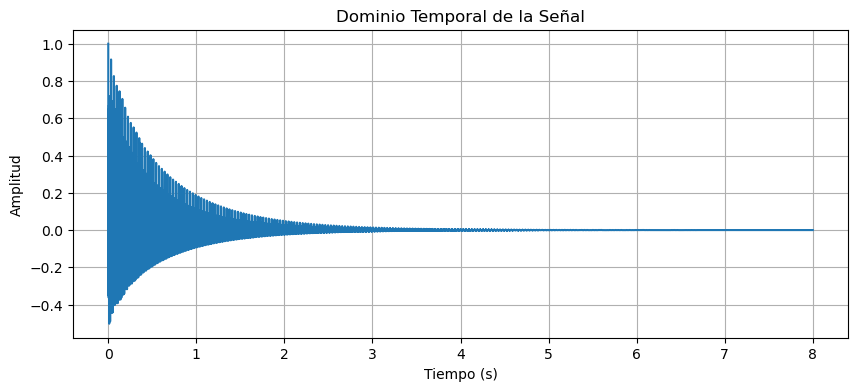

In [6]:
# Graficar dominio temporal
graficar_dominio_temporal(ri, fs)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

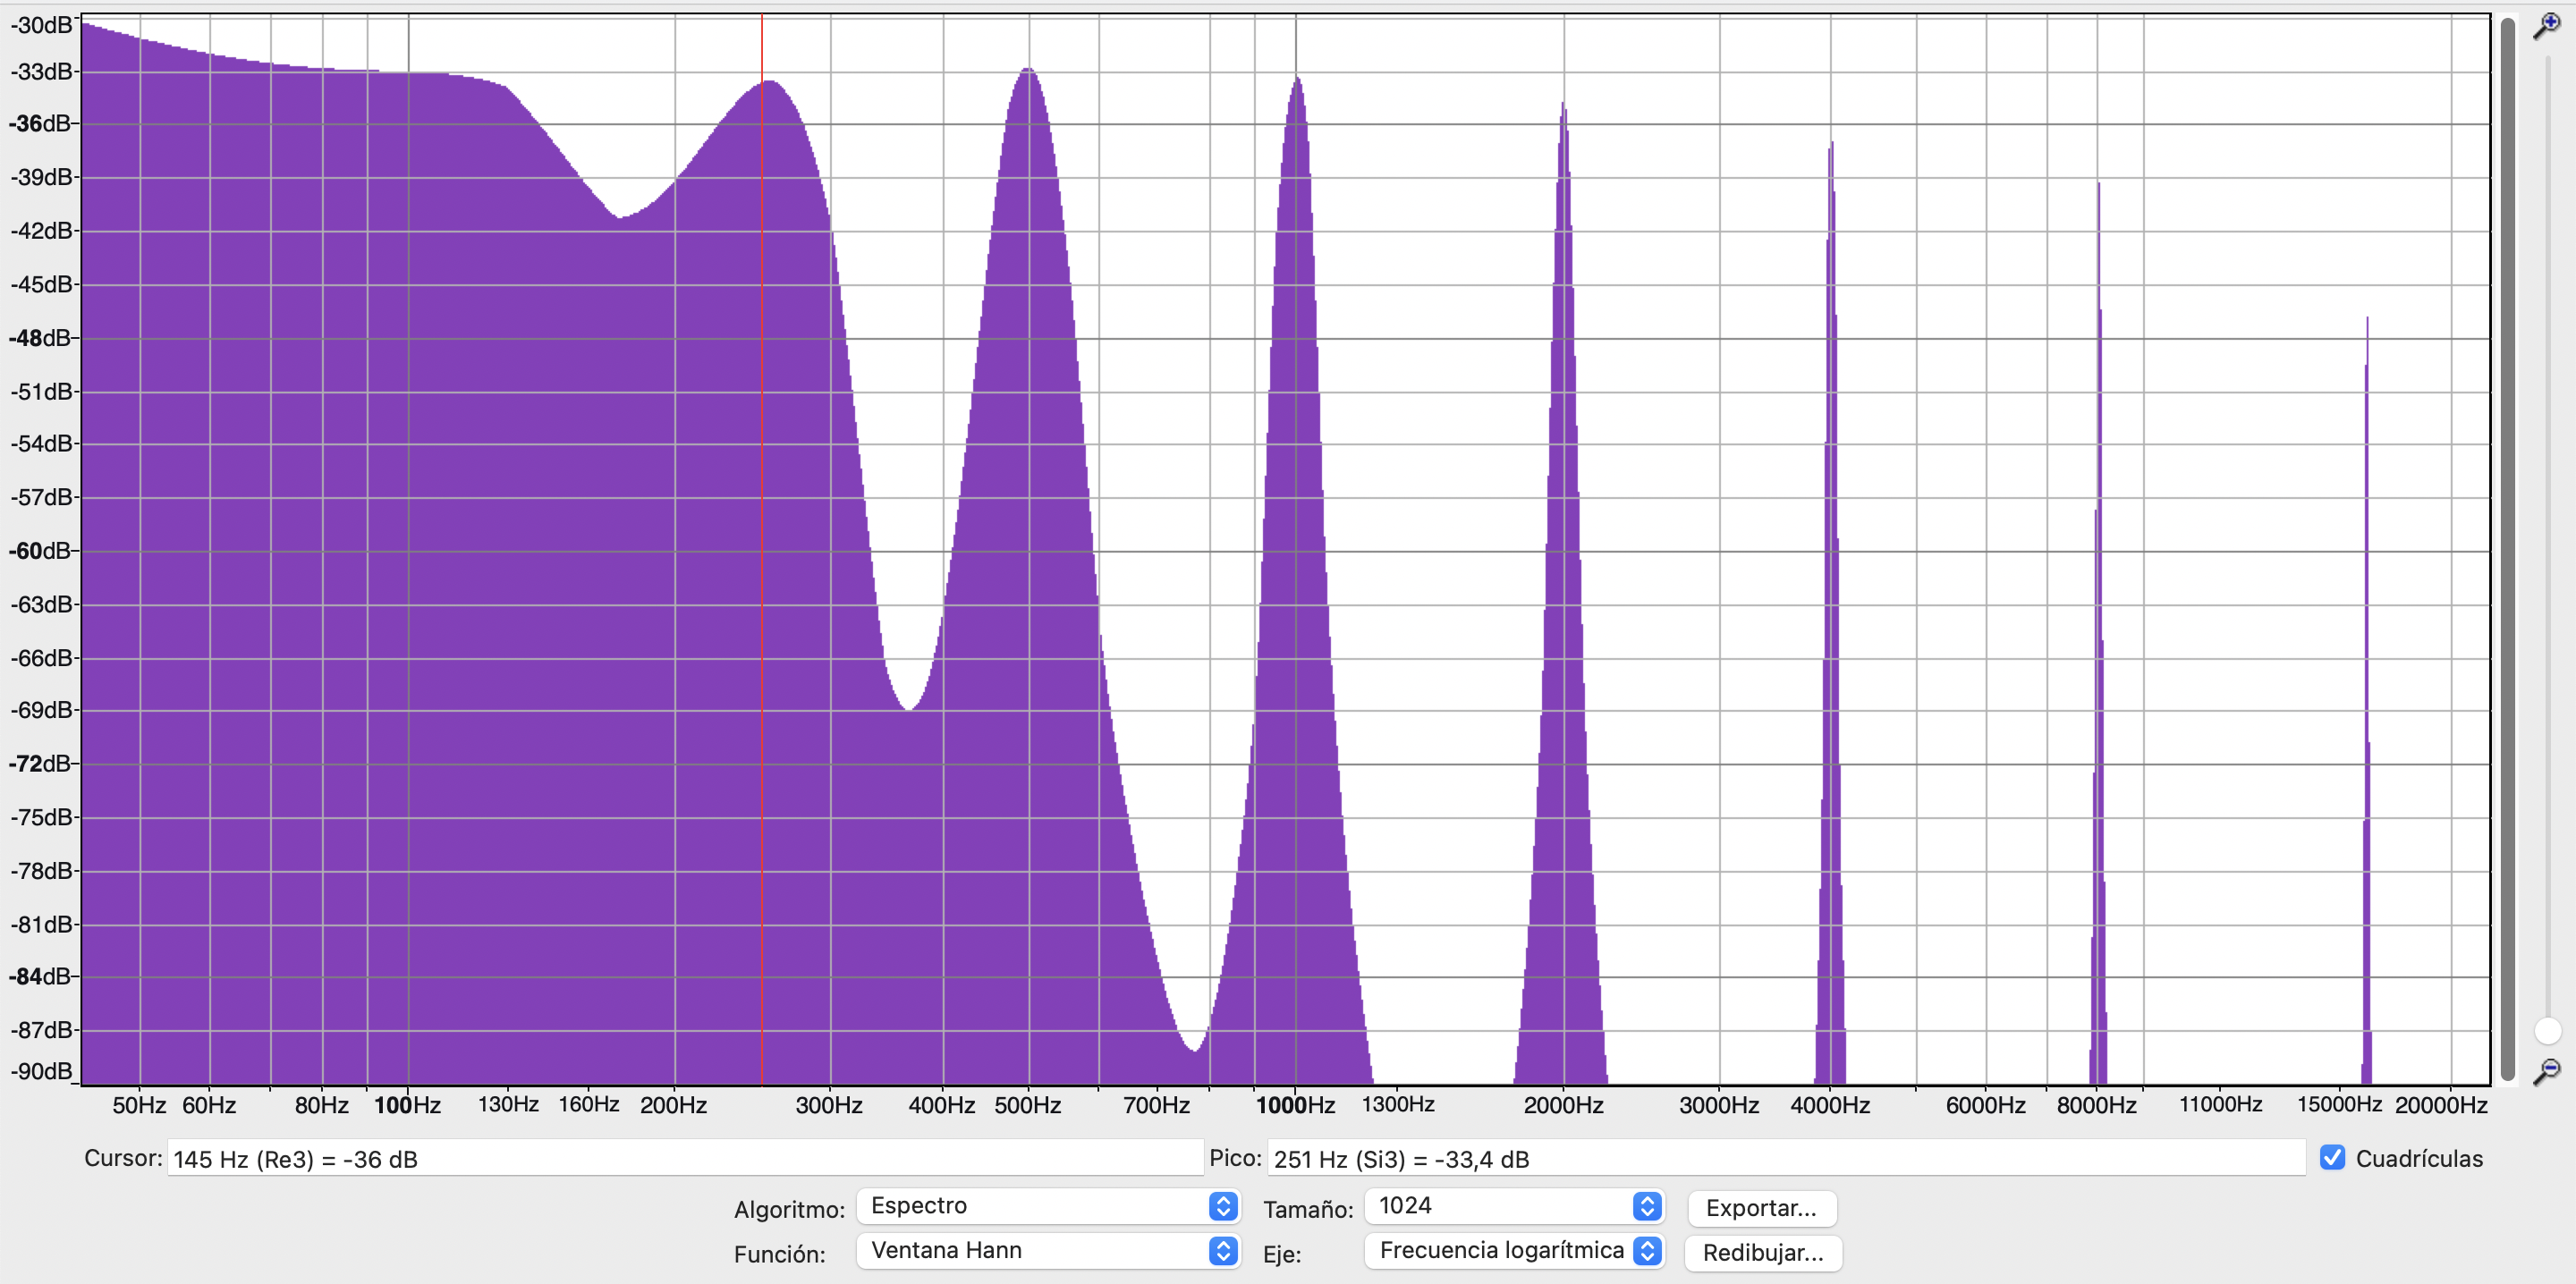

Reproducir señal resultante.

In [7]:
# Guardar como archivo WAV
guardar_wav("RI_R1_Reactor_Hall.wav", ri, fs)

# Reproducir audio
print("Reproduciendo respuesta al impulso sintetizada...")
reproducir_audio(ri, fs)

Reproduciendo respuesta al impulso sintetizada...


Comentar sobre el resultado obtenido, ¿Es una buena aproximación? ¿Qué aspectos estamos dejando de lado en esta sintetización, que en un caso real estan presentes?.

Si bien contiene cierta información sobre el comportamiento del recinto en distintas frecuencias, la versión de respuesta al impulso sintetizada es una suma de exponenciales moduladas por cosenos. Esto nos genera en el espectro unos componentes de frecuencias discretas fijas, centradas en la frecuencia central de cada banda, con un decaimiento constante por banda. 
De esta manera, en un caso real al tratarse de una respuesta al impulso grabada, como las provistas por el sitio OpenAir, las mismas contemplan la geometría del recinto, debido a las sumas o restas de los modos del mismo. 
La respuesta al impulso sintetiza el decaimiento de 60db para bandas de frecuencia específicas, lo que representa una menor resolución en el análisis de comportamiento.
A continuación se realiza el análisis y síntensis de RI por tercio de octava de una señal de RI obtenida de OpenAir a la cual le calculamos el RT60 para cada tercio de octava, lo que aporta una mayor resolución e información sobre el comportamiento del recinto. 

# Ejemplo de Respuesta al impulso sintetizada para tercio de octava

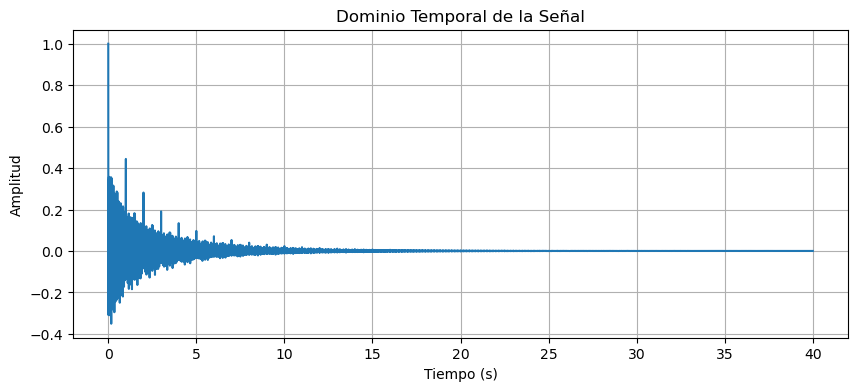

Reproduciendo respuesta al impulso sintetizada (tercios de octava)...


In [8]:
# Datos para tercio de octava
frecuencias_centrales = [
  25, 31, 39, 50, 62, 79, 99, 125, 157, 198,
  250, 315, 397, 500, 630, 794, 1000, 1260, 1587, 2000,
  2520, 3175, 4000, 5040, 6350, 8000, 10079, 12699, 16000
]

t60_por_banda = [
  38.89, 36.02, 29.22, 20.60, 22.32, 23.35, 22.36, 18.38, 18.60, 16.15,
  14.81, 14.29, 13.51, 11.79, 10.66, 10.03, 9.09, 7.85, 6.53, 5.60,
  4.68, 3.66, 2.83, 2.13, 1.56, 1.10, 0.84, 0.64, 0.56
]

# Configuración de síntesis
fs = 44100  # Frecuencia de muestreo
duracion_total = 40.0  # Duración total en segundos (suficiente para el T60 más largo)

# Sintetizar la respuesta al impulso para tercios de octava
t, ri_tercios = sintetizar_respuesta_impulso(
  t60_por_banda=t60_por_banda,
  fs=fs,
  duracion=duracion_total,
  frecuencias_centrales=frecuencias_centrales
)

# Graficar dominio temporal
graficar_dominio_temporal(ri_tercios, fs)

# Guardar como archivo WAV
guardar_wav("RI_Tercios_Octava.wav", ri_tercios, fs)

# Reproducir audio
print("Reproduciendo respuesta al impulso sintetizada (tercios de octava)...")
reproducir_audio(ri_tercios, fs)

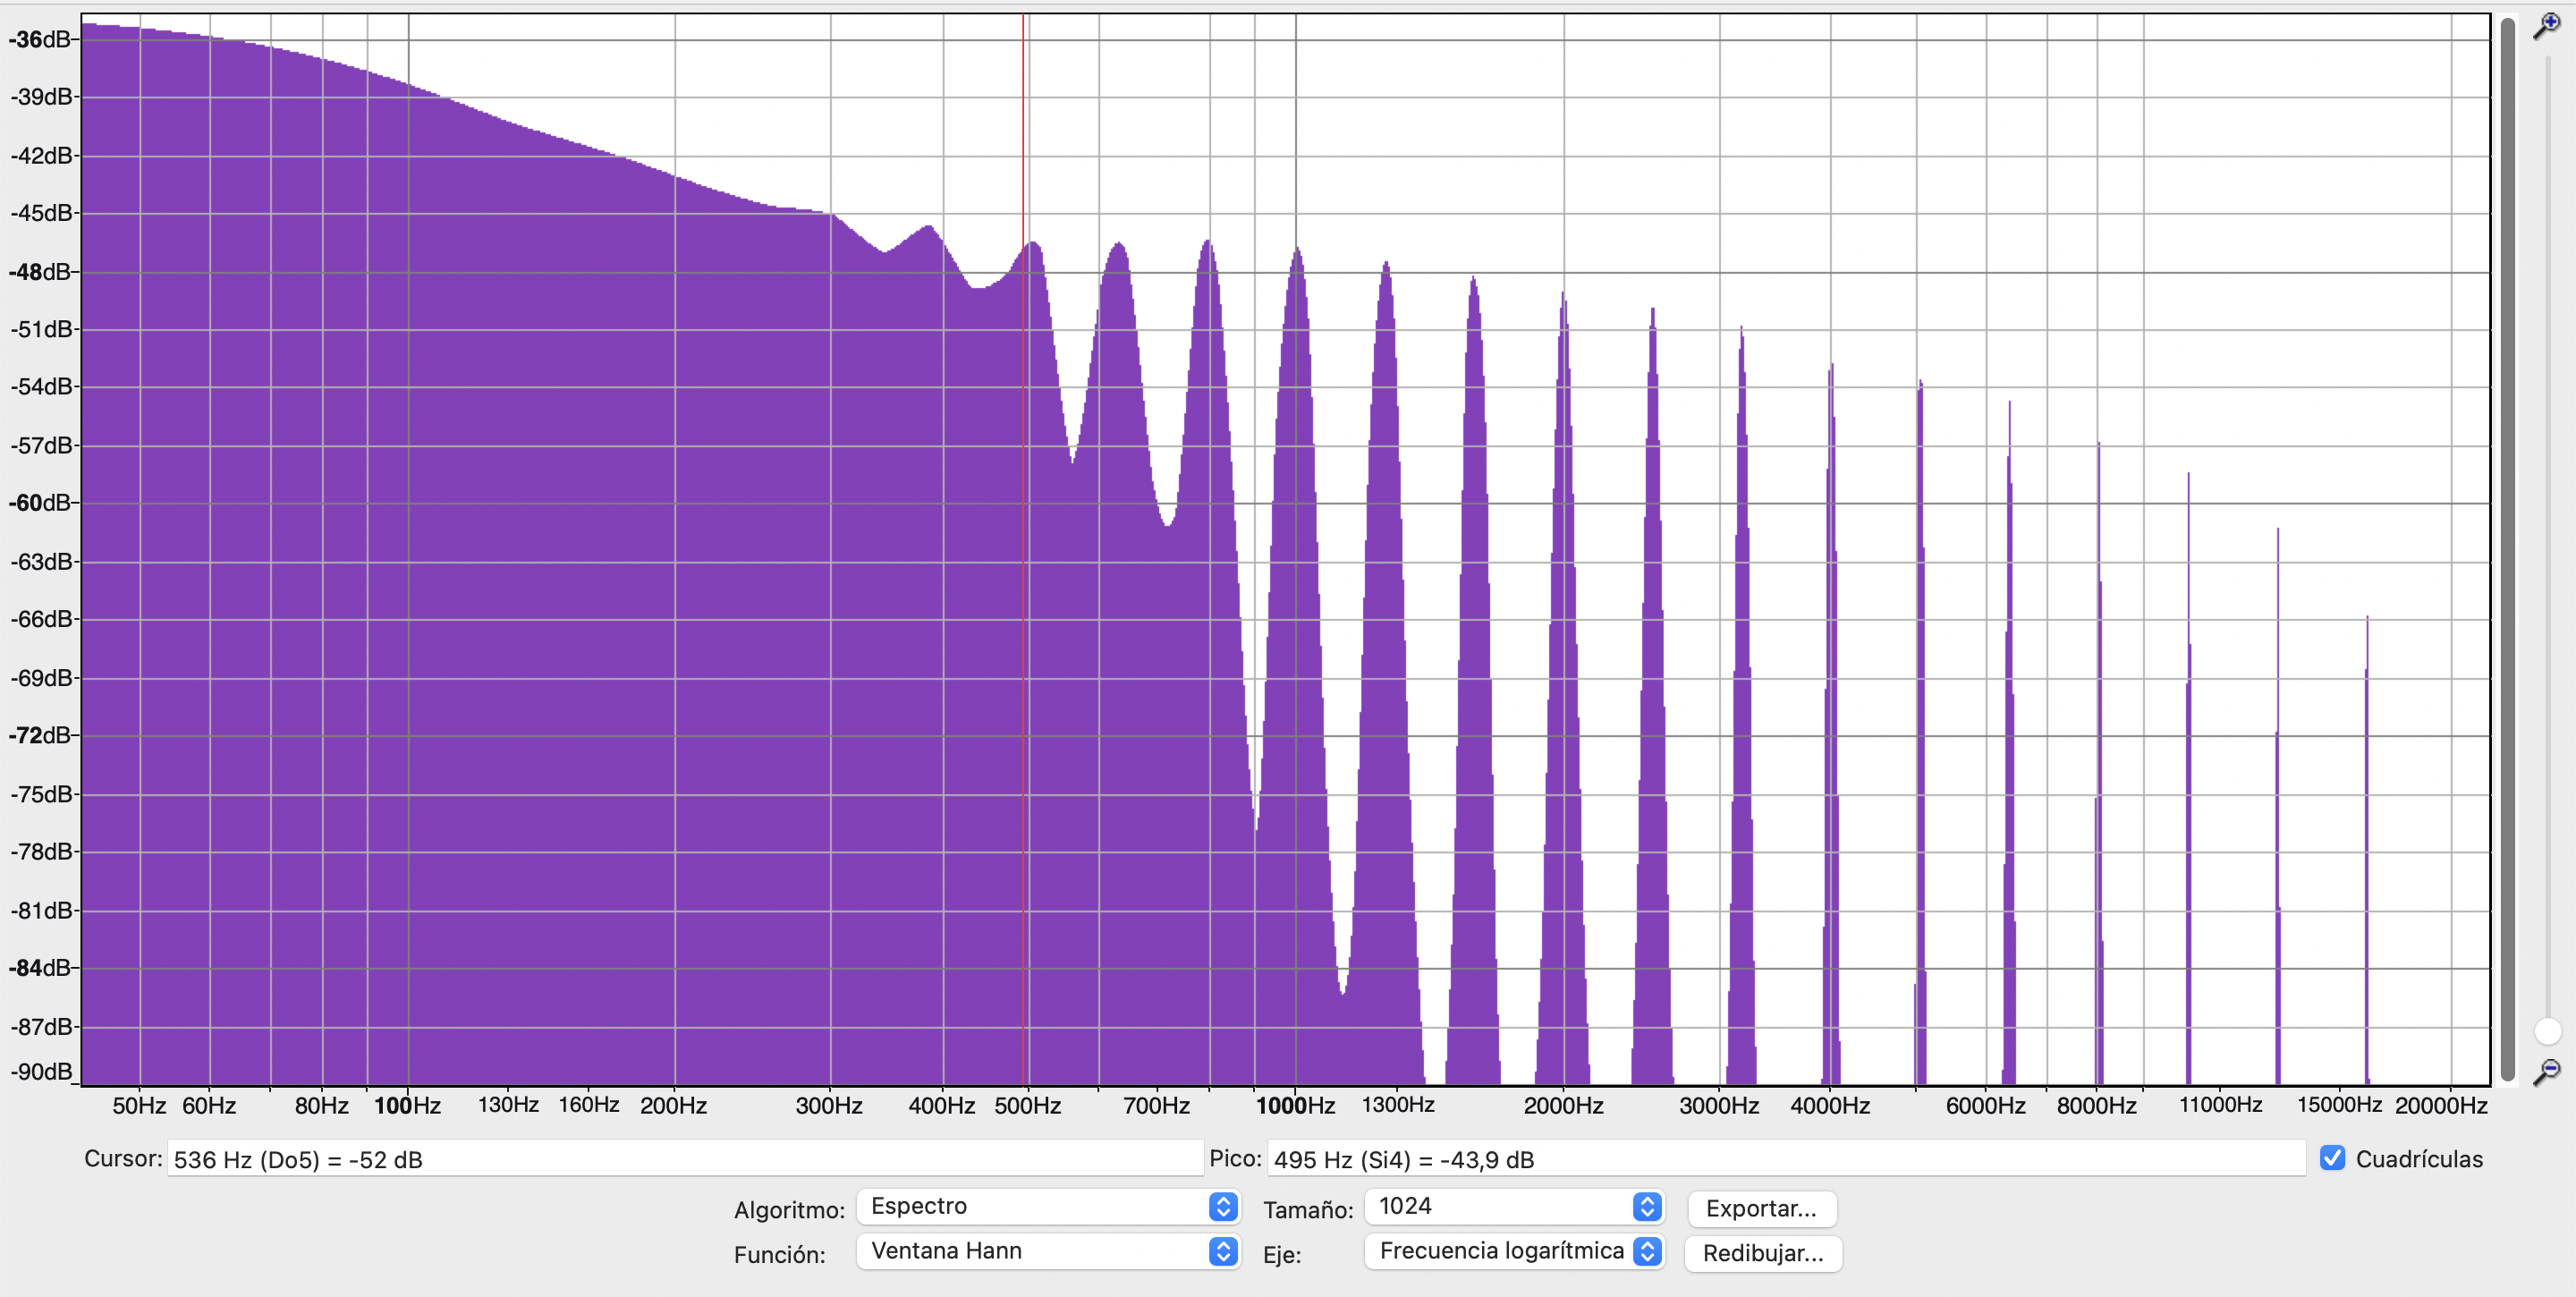

## Función obtener respuesta al impulso

**Consigna:** realizar una función que permita obtener la respuesta al impulso en formato de señal de audio .wav, a partir del sinesweep logarítmico grabado y el filtro inverso generado utilizando el siguiente método: 

Supongamos que un recinto es excitado por una señal sinesweep logarítmica $x(t)$ y captada por un micrófono $y(t)$ y buscamos la RI del recinto $h(t)$, lo anterior se expresa de la siguiente manera:

\begin{equation}
y(t)=x(t)*h(t)
\tag{9}
\end{equation}

Para un sine sweep lineal (que no es nuestro caso) el problema es sencillo, pero en nuestro caso (sine sweep logarítmico) requiere trabajar un poco respecto $x(t)$ para obtener la siguiente expresión:

\begin{equation}
h(t) = F^{-1}[H(jw)]=F^{-1}[Y(jw)K(jw)]
\tag{10}
\end{equation}

Recordar que $k(t)$ es el filtro inverso (ecu.5) y $K(jw)$ su respectiva transformada de fourier. De esta manera se obtiene la respuesta al impulso buscada.

> El desarrollo matemático de la anterior expresión se encuentra en el [Anexo I - Obtener la respuesta al impulso a partir de un sine sweep](../consigna_TP_matlab.pdf) (p.14) del instructivo para Matlab del TP.

In [4]:
def funcRI(fi, sine):
    datosfi, fs = sf.read(fi)  # Cargar el archivo de respuesta al impulso
    datossine, fs = sf.read(sine)  # Cargar el archivo de señal de entrada (sine sweep)
    # Realizar la convolución
    RI = signal.fftconvolve(datossine, datosfi, mode='full')
    # Normalizar la señal resultante y grabarla como un archivo WAV   
    return RI

def normalizar_senial(f,t):
    """Docstring for normalizar_senial
    
    :param f: Senial
    :type f: tupla
    :param t: tiempo
    :type t: tupla
    :return: Senial y tiempo normalizado
    :rtype: tuplas"""
    nf = f/np.max(np.abs(f))
    nt = t/np.max(np.abs(t))
    return (nf, nt)



Llamar a la función con un sine sweep y su respectivo filtro inverso creados con la función de la primer entrega (**no** los descargados).

Archivos seleccionados:
- /Users/federicoalberetti/TP_sys_1ra_entrega_Gonzalez_Alberetti-1/filtro_inverso.wav
- /Users/federicoalberetti/TP_sys_1ra_entrega_Gonzalez_Alberetti-1/sine_sweep.wav

Archivo: /Users/federicoalberetti/TP_sys_1ra_entrega_Gonzalez_Alberetti-1/filtro_inverso.wav
Frecuencia de muestreo: 44100 Hz
Duración: 5.00 segundos


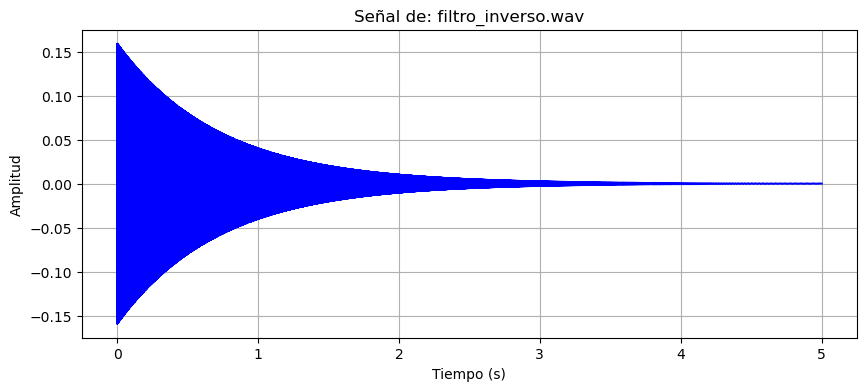


Archivo: /Users/federicoalberetti/TP_sys_1ra_entrega_Gonzalez_Alberetti-1/sine_sweep.wav
Frecuencia de muestreo: 44100 Hz
Duración: 5.00 segundos


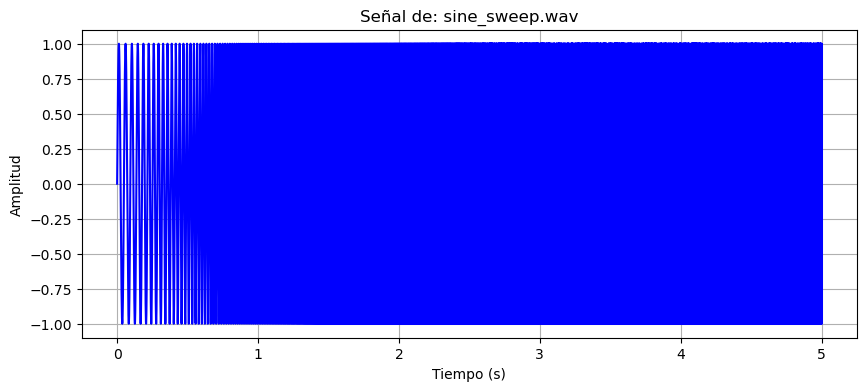

In [27]:
# Seleccionar sine_sweep.wav y filtro_inverso.wav

files = []
select_and_load_files(fileselect)  # Llamar a la función para cargar archivos al inicio


In [24]:
fs=44100

# Verificamos que haya 2 archivos seleccionados
if len(files) != 2:
    print("⚠️ Debes seleccionar exactamente 2 archivos: primero el filtro inverso, luego el sine sweep.")
else:
    filtro_inverso_path = files[0]
    sine_sweep_path = files[1]

    # Ejecutar función de convolución
    convolucionFIconRI = funcRI(filtro_inverso_path, sine_sweep_path)

    # Vector de tiempo (si tu normalización lo necesita)
    t = np.linspace(0, len(convolucionFIconRI) / fs, num=len(convolucionFIconRI))

    # Normalizar
 
    normconvFIconsinsweep = normalizar_senial(convolucionFIconRI, t)[0]



Visualizar la señal con la función creada en la primer entrega.

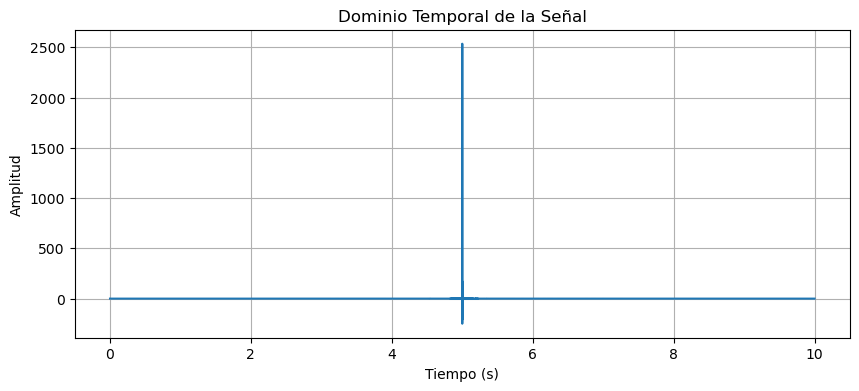

In [25]:
# Graficar dominio temporal
graficar_dominio_temporal(convolucionFIconRI, fs)

Reproducir señal resultante.

In [18]:
    # Guardar
    guardar_wav("convolucion_FI_con_sinesweep.wav", normconvFIconsinsweep, fs=fs)
    reproducir_audio(normconvFIconsinsweep,fs=fs)
    print("✅ Archivo guardado como 'convolucion_FI_con_sinesweep.wav'")

✅ Archivo guardado como 'convolucion_FI_con_sinesweep.wav'


Comentar sobre el resultado obtenido. ¿Qué es lo que se esta escuchando? Realizar el mismo procedimiento con la señal descargada y el filtro inverso generado (para dicho sine sweep)

Lo que se está escuchando luego de la convolución del sine sweep y el filtro inverso es un impulso, que nos da la información sobre el sistema que procesa la convolución, en este caso la computadora que ejecute el software. 

Archivos seleccionados:
- /Users/federicoalberetti/TP_sys_1ra_entrega_Gonzalez_Alberetti-1/Toma_n3_c-03.wav
- /Users/federicoalberetti/TP_sys_1ra_entrega_Gonzalez_Alberetti-1/filtro_inversoDRIVE.wav

Archivo: /Users/federicoalberetti/TP_sys_1ra_entrega_Gonzalez_Alberetti-1/Toma_n3_c-03.wav
Frecuencia de muestreo: 44100 Hz
Duración: 33.25 segundos


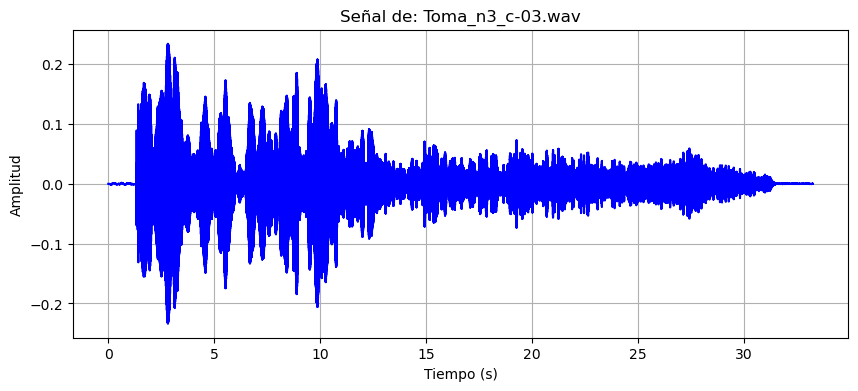


Archivo: /Users/federicoalberetti/TP_sys_1ra_entrega_Gonzalez_Alberetti-1/filtro_inversoDRIVE.wav
Frecuencia de muestreo: 44100 Hz
Duración: 30.00 segundos


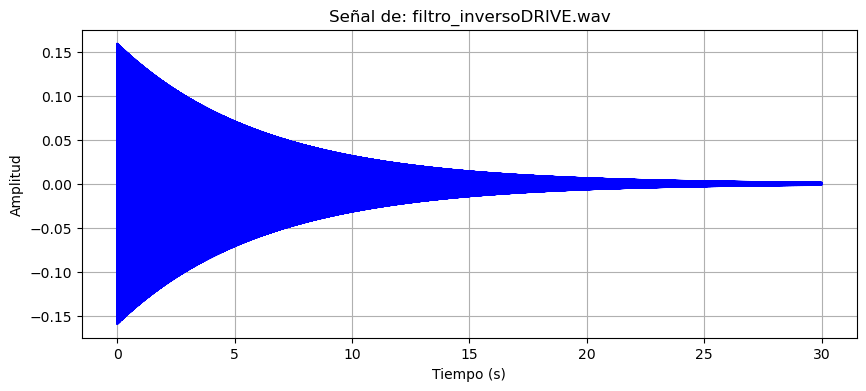

In [28]:
#elegir los archivos de sinesweep aula(Toma_n3_c-03.wav) y su filtro inverso que generamos(filtro_inversoDRIVE.wav)
files = []   
select_and_load_files(fileselect)  # Llamar a la función para cargar archivos al inicio

fs=44100

# Verificamos que haya 2 archivos seleccionados
if len(files) != 2:
    print("⚠️ Debes seleccionar exactamente 2 archivos: primero el filtro inverso, luego el sine sweep.")
else:
    filtro_inverso_path = files[0]
    sine_sweep_path = files[1]

    # Ejecutar función de convolución
    convolucionFIconRI = funcRI(filtro_inverso_path, sine_sweep_path)

    # Vector de tiempo (si tu normalización lo necesita)
    t = np.linspace(0, len(convolucionFIconRI) / fs, num=len(convolucionFIconRI))

    # Normalizar
    normconvFIconsinsweepAULA = normalizar_senial(convolucionFIconRI, t)[0]





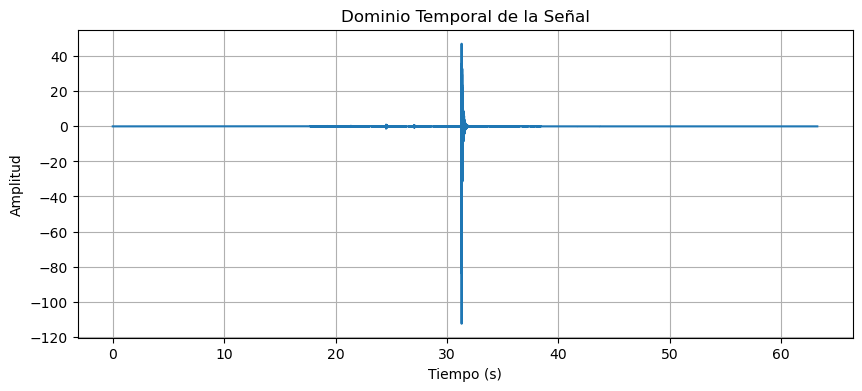

✅ Archivo guardado como 'AULAconvolucion_FI_con_sinesweep.wav'


In [29]:
# Graficar dominio temporal
graficar_dominio_temporal(convolucionFIconRI, fs)

 # Guardar
guardar_wav("AULAconvolucion_FI_con_sinesweep.wav", normconvFIconsinsweepAULA, fs=fs)
reproducir_audio(normconvFIconsinsweepAULA,fs=fs)
print("✅ Archivo guardado como 'AULAconvolucion_FI_con_sinesweep.wav'")

La diferencia con el impulso obtenido a partir del sine sweep grabado del aula, es que en ese caso nos aporta información sobre el comportamiento general del recinto, desde las early reflections, el rt 60 para cada frecuencia o el rt60 en general, entre otros parámetros que se pueden obtener a partir de la medición. 

## Función filtros norma IEC61260

**Consigna**: Realizar una función que filtre todas las señales en octavas y tercio de octava según la norma IEC61260, con el objetivo de calcular los parámetros acústicos discriminando las frecuencias. 

Para lo cual utilizar las funciones del modulo [signals de scipy](https://docs.scipy.org/doc/scipy/reference/signal.html). Se adjunta el código capaz de calcular los coeficientes del filtro y aplicarlos a una señal. La función debe completarse con el código necesario para que este proceso se repita para cada una de las frecuencias centrales determinadas en la norma. Así mismo, el primer argumento de la función [iirfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html) determina el grado del filtro. Evaluar el valor del mismo para que la frecuencia central de la banda coincida con las especificadas en la norma.

> Para ver una introducción breve a la implementación de filtros, usar el siguiente [documento](https://github.com/maxiyommi/signal-systems/blob/master/material_extra/Filtros/intro_filtros.ipynb).

In [5]:
def filtronorma(senial, fs, tipo='octava', order=4):
    audiodata, fs = sf.read(senial)
    """
    Aplica filtros de octava o tercio de octava según norma IEC 61260.
    
    Parámetros:
        audiodata (array): Señal de audio.
        fs (float): Frecuencia de muestreo (Hz).
        band_type (str): 'octave' o 'third-octave'.
        order (int): Orden del filtro (recomendado: 4).
        zero_phase (bool): Si True, usa filtrado sin fase (filtfilt).
    
    Retorna:
        dict: {frecuencia_central: señal_filtrada}
    """
    # Definir frecuencias centrales según IEC 61260
    if tipo == 'octava':
        centers = [31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
        G = 1.0  # Ancho de banda para octava
    elif tipo == 'third-octave':
        centers = [12.5, 16, 20, 25, 31.5, 40, 50, 63, 80, 100, 125, 160, 200, 
                   250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 
                   3150, 4000, 5000, 6300, 8000, 10000, 12500, 16000, 20000]
        G = 1.0 / 3.0  # Ancho de banda para tercio
    else:
        raise ValueError("band_type debe ser 'octave' o 'third-octave'")

    factor = 2 ** (G / 2)  # Cálculo del factor de banda
    nyquist = fs / 2
    filtroporbandas = {}

    for fc in centers:
        # Calcular frecuencias de corte
        lower = fc / factor
        upper = fc * factor
        
        # Saltar bandas que exceden Nyquist
        if upper > nyquist:
            continue
        
        # Diseñar filtro Butterworth en formato SOS
        sos = signal.iirfilter(
            N=order, 
            Wn=[lower, upper], 
            btype='band', 
            analog=False, 
            ftype='butter', 
            fs=fs, 
            output='sos'
        )
        
 
        filtered_data = signal.sosfilt(sos, audiodata)
        
        filtroporbandas[fc] = filtered_data

    return filtroporbandas

Archivos seleccionados:
- /Users/federicoalberetti/TP_sys_1ra_entrega_Gonzalez_Alberetti-1/RI_reactor.wav

Archivo: /Users/federicoalberetti/TP_sys_1ra_entrega_Gonzalez_Alberetti-1/RI_reactor.wav
Frecuencia de muestreo: 44100 Hz
Duración: 19.94 segundos


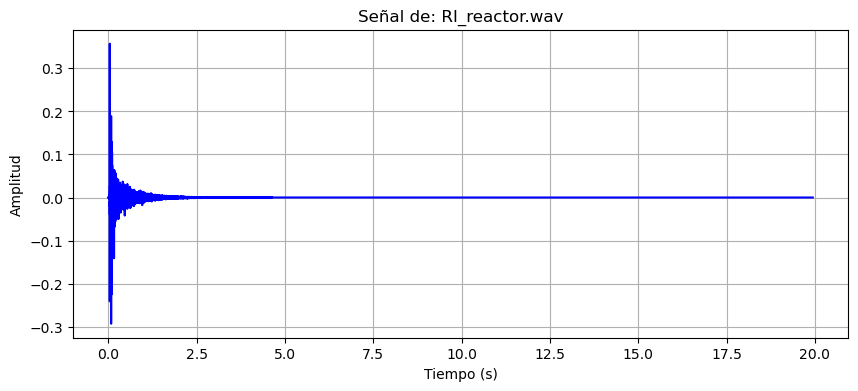

In [6]:
#Elegir cualquier RI, nosotros usamos RI_R1_Reactor_Hall.wav
files = []
select_and_load_files(fileselect)  # Llamar a la función para cargar archivos al inicio

In [9]:
# Selección de archivo, usamos RI_R1_Reactor_Hall.wav
archivo_seleccionado = files[0]  # O pedirle al usuario que se asegure cuál usar

# Parámetros
fs = 44100  # Frecuencia de muestreo
freccentral = 1000  # Frecuencia central para el filtro

# Aplicar el filtro por bandas
senialporbandas = filtronorma(archivo_seleccionado, fs=fs, tipo='octava', order=4)

# Guardar el archivo filtrado
guardar_wav("convolucion_FI_con_Sinesweepaula1000hz.wav", senialporbandas[freccentral], fs=fs)

# Reproducir audio
reproducir_audio(senialporbandas[freccentral], fs=fs)


Llamar a la función con alguna RI generada anteriormente.

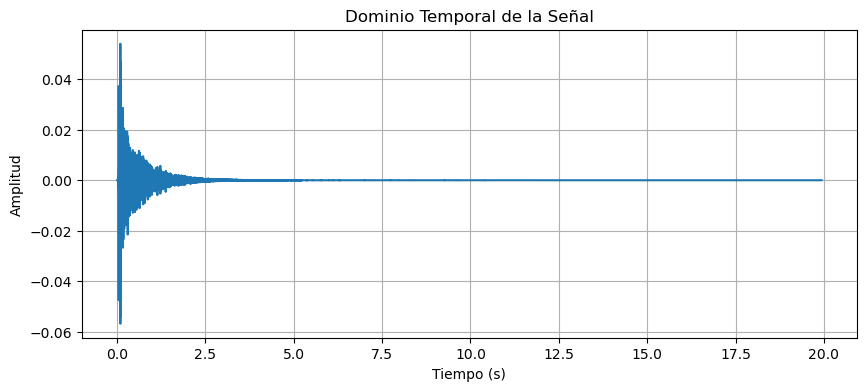

In [10]:
# Graficar en el dominio temporal
graficar_dominio_temporal(senialporbandas[freccentral], frecuencia_muestreo=fs)


Graficar el dominio espectral del resultado en una banda, utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

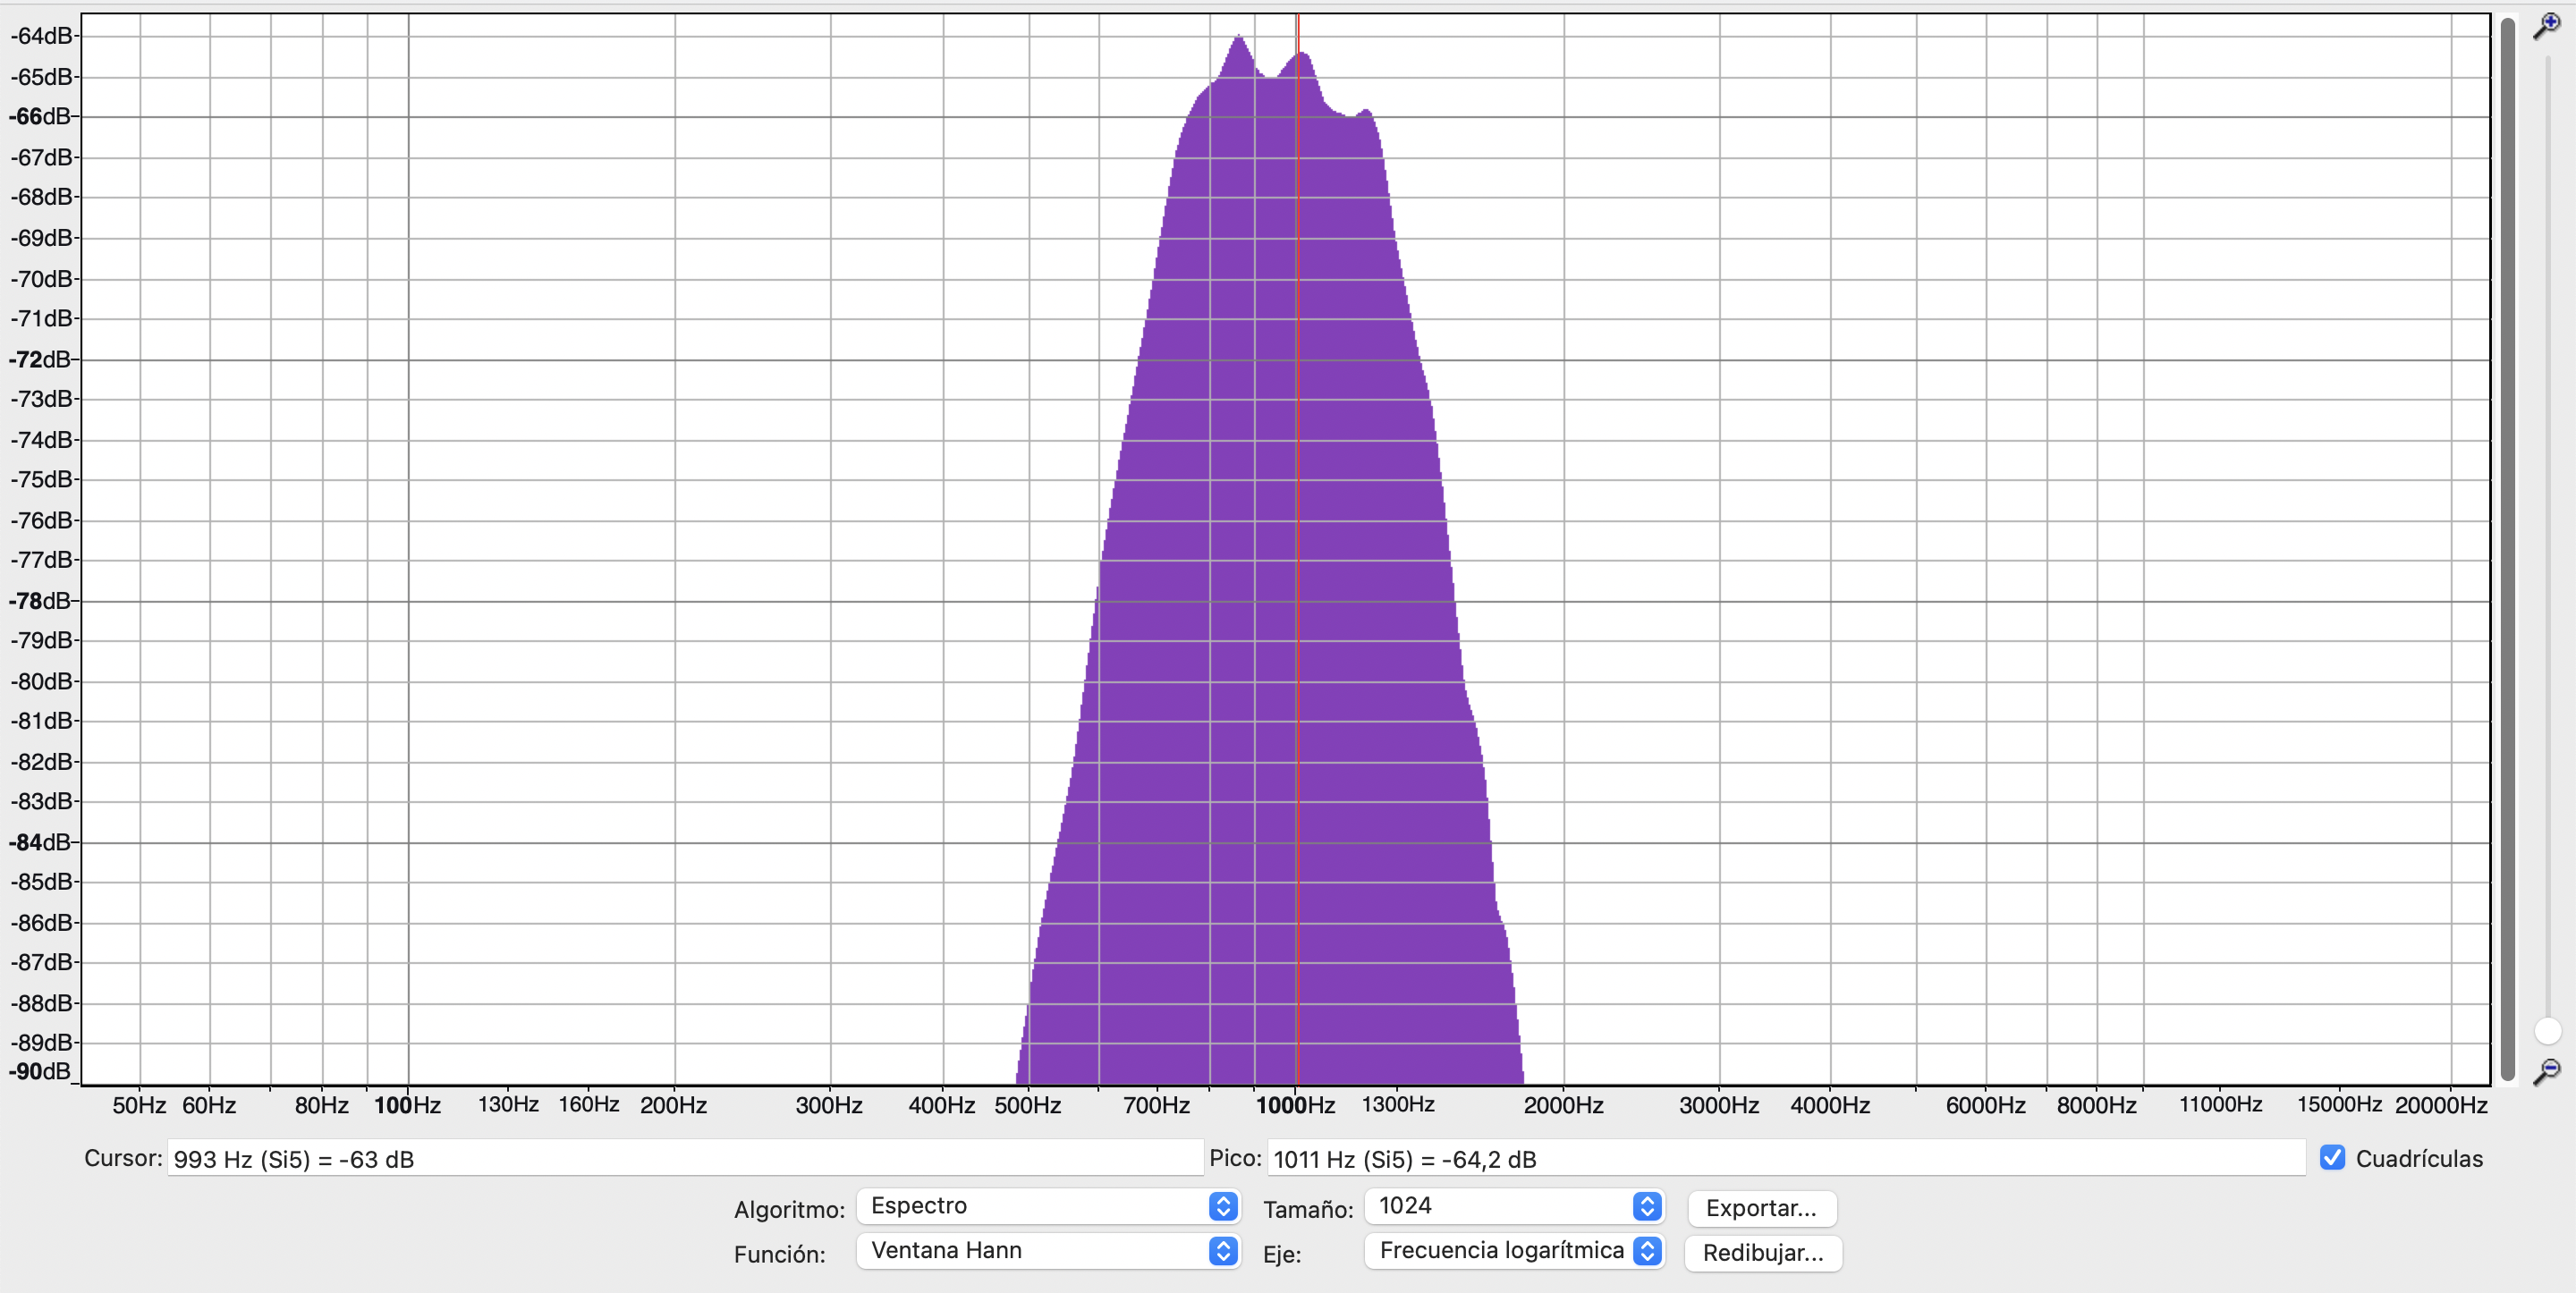

¿El resultado es el esperado? ¿Cumple con los requerimientos de la normativa?

Segun la normativa IEC61260 Frecuencias Centrales Normalizadas:

Octava: 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000 Hz.

Tercio de Octava: 12.5, 16, 20, 25, 31.5, 40, 50, 63, 80, 100, 125, 160, 200, 250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150, 4000, 5000, 6300, 8000, 10000, 12500, 16000, 20000 Hz.

Sí, este resultado cumple con la norma para Clase 1, utilizando un orden de filtro de 4 o mayor para el filtro Butterworth.

A ±1 banda adyacente (aproximadamente ±23% para un tercio de octava, es decir ≈890 Hz y ≈1120 Hz), la atenuación mínima requerida es 60 dB.

En tu medición, por ejemplo a 993 Hz, se observa una atenuación de –63 dB, lo cual supera el mínimo exigido.

También se ve que la pendiente fuera de banda es suficientemente pronunciada, lo que sugiere un orden de filtro adecuado.

## Función conversión a escala logarítmica normalizada
Para visualizar correctamente la señal es necesario realizar una función que convierta la respuesta al impulso en escala logarítmica, utilizando la siguiente expresión:

\begin{equation}
    R(t) = 20\log_{10}\frac{A(t)}{A(t)_{max}}
\tag{11}
\end{equation}

Donde $A(t)$ es la señal que deseamos transformar de escala. **Consigna:** crear una función que convierta a escala logarítmica la RI que ingresa y devuelva un array con la señal resultante.

In [15]:
import numpy as np
import soundfile as sf

def ir_a_log(archivo):
    """
    Convierte una respuesta al impulso (RI) a escala logarítmica normalizada.
    Fórmula: R(t) = 20 * log10( |A(t)| / max(|A(t)|) )

    Parámetros:
        archivo : str
            Ruta del archivo de audio .wav

    Retorna:
        np.array: Señal en escala logarítmica (dB)
    """
    audiodata, fs = sf.read(archivo)
    audiodata = np.asarray(audiodata)

    A_max = np.max(np.abs(audiodata))

    if A_max == 0:
        return np.full_like(audiodata, -np.inf)

    # Se normaliza y se asegura que no haya ceros antes de aplicar log10
    normalizado = np.abs(audiodata) / A_max
    normalizado[normalizado == 0] = 1e-12  # evita log10(0)

    irlog = 20 * np.log10(normalizado)

    return irlog


Llamar a la función con alguna de las señales generadas anteriormente.

Archivos seleccionados:
- /Users/federicoalberetti/TP_sys_1ra_entrega_Gonzalez_Alberetti-1/RI_sintetizada.wav

Archivo: /Users/federicoalberetti/TP_sys_1ra_entrega_Gonzalez_Alberetti-1/RI_sintetizada.wav
Frecuencia de muestreo: 44100 Hz
Duración: 8.00 segundos


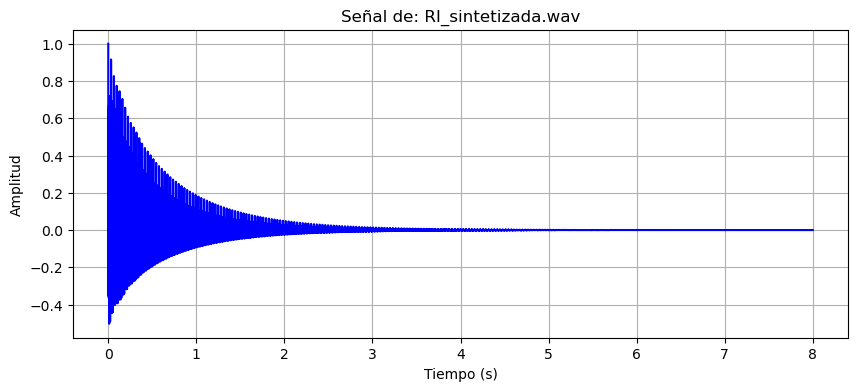

In [18]:
# Elegimos RI_Tercios_Octava.wav
files = []
select_and_load_files(fileselect)  # Llamar a la función para cargar archivos al inicio

# Selección de archivo (se espera que el usuario ya haya seleccionado 1 archivo)
archivo_seleccionado = files[0]  # O pedirle al usuario que se asegure cuál usar

RIfiltnormlog = ir_a_log(archivo_seleccionado)


Visualizar la señal con la función creada en la primer entrega.

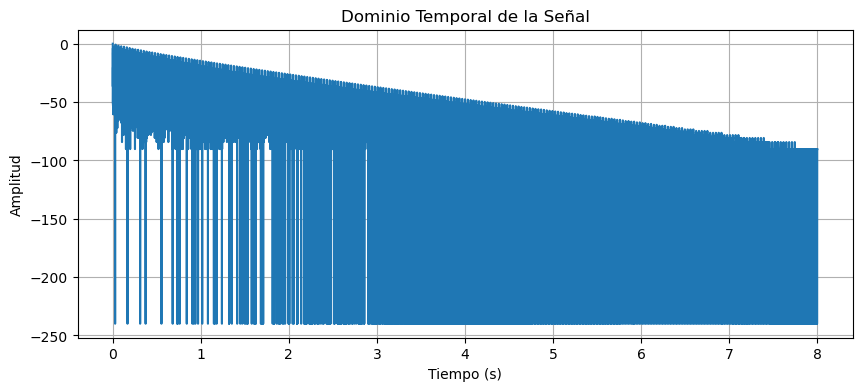

In [19]:
graficar_dominio_temporal(RIfiltnormlog, frecuencia_muestreo=fs)

### Informe preliminar (opcional)
Realizar un informe preliminar en formato UNTREF para memorias cuatrimestrales (disponible en el Drive de la asignatura), utilizando la plataforma de dición de documentos [LaTeX](https://es.wikipedia.org/wiki/LaTeX). Respetar las siguientes consignas:
1. Mencionar los detalles en el diseño de los scripts(con ayuda de diagramas de flujo o pseudocódigo) sin agregar código propiamente dicho.
2. Describir el dataset seleccionado para probar el software.
3. El informe debe reflejar la arquitectura del software desarrollado y los avances en la producción del mismo. Los datos que se informan tienen que ser relevantes y garantizar la reproducibilidad de los mismos. No ahondar en muchos detalles teóricos y definiciones(hacer uso de referencias),hacer más bien foco en la producción del software, su evaluación y su validación.
4. El informe preliminar no debe exceder las 3 páginas. Respetar fecha de entrega.
5. Respetar los siguientes porcentajes de contenido por sección(también determinan los grados de importancia)

A modo ilustrastivo se muestra los porcentajes del contenido en los informes:

| Resumen | Introducción | Marco teórico | Desarrollo experimental | Resultados | Conclusiones |
| -- | -- | -- | -- | -- | --  |
| 5% | 10% | 10% | 25% | 30% | 20% |

> Más información en el siguiente [link](https://github.com/maxiyommi/signal-systems/tree/master/trabajo_practico#informe-t%C3%A9cnico).